# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [ ]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [ ]:
# Здесь все нормально
df_titanic.Survived.value_counts()

In [ ]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

In [ ]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [ ]:
df_titanic.Embarked.head()

In [ ]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

In [ ]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [ ]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [ ]:
bow

In [ ]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [ ]:
df_wine.head()

Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [ ]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [ ]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

In [ ]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [ ]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [ ]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Получаем предсказание модели (на обучающей выборке)

In [ ]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [ ]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [ ]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

In [ ]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [ ]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [10]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.spatial.distance import cdist
import numpy as np

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init

    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))
        
        if self.init == 'k-means':
            self.k_means(X, y)
        else:
            self.centroids = X[np.random.choice(X.shape[0], self.k)]
            
        for it in xrange(self.max_iter):                    
            X_norm = cdist(X, self.centroids, self.metric)
            if (self.labels != X_norm.argmin(axis=1)).sum(axis=0) != 0:
                self.labels = X_norm.argmin(axis=1)
            else:
                break
            for i in xrange(self.k):
                self.centroids[i] = X[self.labels == i].mean(axis=0)
        
        return self
    
    def k_means(self, X, y=None):
        self.centroids[0] = X[np.random.randint(X.shape[0])]
        distance = np.empty(X.shape[0])
        for i in xrange(1, self.k):
            X_norm = cdist(X, self.centroids[:i], self.metric)
            distance = X_norm.min(axis=1).cumsum()
            rnd_sum = np.random.random() * distance[-1]
            self.centroids[i] = X[int(np.argwhere(distance > rnd_sum)[0])]
        return self 

    def predict(self, X, y=None):
        
        return self.labels


In [50]:
class MiniBatchKMeans(Kmeans):
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', eps=1e-6, b_size=100):
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.eps = eps
        self.b_size = b_size
        
    def fit(self, X, y=None):
        
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))
        quantity = np.zeros((self.k, 1))
        
        if self.init == 'k-means':
            self.k_means(X, y)
        else:
            self.centroids = X[np.random.choice(X.shape[0], self.k)]
        
        prev_centroids = self.centroids
        for it in xrange(self.max_iter):
            batch = np.random.choice(X.shape[0], self.b_size)
            X_norm = cdist(X[batch], self.centroids, self.metric)
            self.labels[batch] = X_norm.argmin(axis=1)
            
            for i in batch:
                c = int(self.labels[i])
                quantity[c] += 1
                n = 1. / quantity[c]
                self.centroids[c] = self.centroids[c] * (1 - n) + X[i] * n

            if np.linalg.norm(cdist(self.centroids, prev_centroids, self.metric)) <= self.eps:
                break
            else:
                prev_centroids = self.centroids
                
        return self
     
    def predict(self, X, y=None):
        
        return self.labels

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [38]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

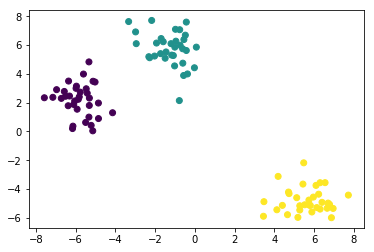

In [40]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

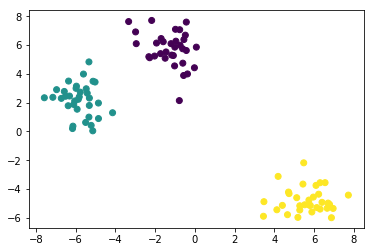

In [41]:
## Работоспособность KMeans

model = Kmeans(k=3, max_iter=100, random_state=1)
model.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=model.labels)

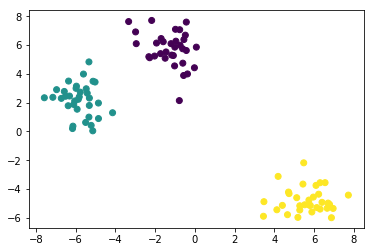

In [42]:
## Работоспособность KMeans++

model = Kmeans(k=3, random_state=1000, init='k-means')
model.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=model.labels)

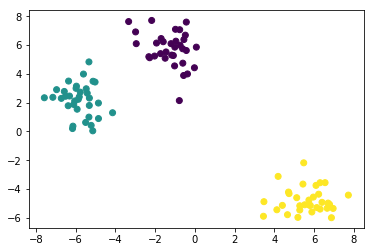

In [43]:
## Работоспособность KMeans с MiniBatchKMeans

model = MiniBatchKMeans(k=3, max_iter=100, random_state=10, b_size=70)
model.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=model.labels)


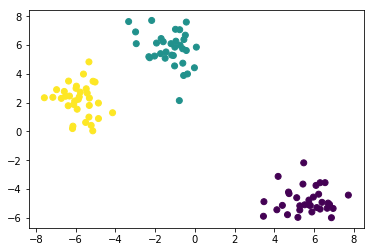

In [44]:
## Работоспособность KMeans++ с MiniBatchKMeans
new = MiniBatchKMeans(k=3, max_iter=100, random_state=12345, init='k-means', b_size=70)
new.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=new.labels)

1000 loops, best of 3: 558 µs per loop
1000 loops, best of 3: 425 µs per loop
1000 loops, best of 3: 437 µs per loop
1000 loops, best of 3: 246 µs per loop
The slowest run took 4.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 222 µs per loop
1000 loops, best of 3: 323 µs per loop


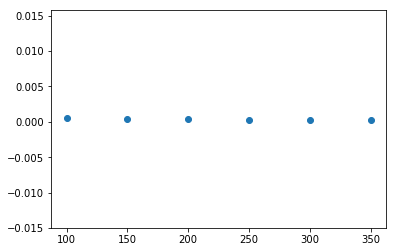

In [45]:
## Время выполнения алгоритма KMeans
n_point = 1000
samples = np.array([100, 150, 200, 250, 300, 350])
sample_time = np.empty((1, 6))
model = Kmeans(k=3, metric='euclidean', max_iter=1000, random_state=10, init='random')
for i, sample in enumerate(samples):
    X, y = make_blobs(n_samples=sample, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    res = %timeit -o model.fit(X, y)
    sample_time[0, i] = res.best
plt.scatter(samples, sample_time) 

1000 loops, best of 3: 391 µs per loop
1000 loops, best of 3: 551 µs per loop
1000 loops, best of 3: 399 µs per loop
1000 loops, best of 3: 606 µs per loop
1000 loops, best of 3: 402 µs per loop
1000 loops, best of 3: 648 µs per loop


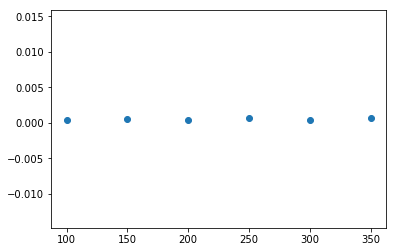

In [46]:
## Время выполнения алгоритма KMeans++
n_point = 1000
samples = np.array([100, 150, 200, 250, 300, 350])
sample_time = np.empty((1, 6))
model = Kmeans(k=3, metric='euclidean', max_iter=1000, random_state=10, init='k-means')
for i, sample in enumerate(samples):
    X, y = make_blobs(n_samples=sample, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    res = %timeit -o model.fit(X, y)
    sample_time[0, i] = res.best
plt.scatter(samples, sample_time) 

10 loops, best of 3: 166 ms per loop
10 loops, best of 3: 166 ms per loop
10 loops, best of 3: 165 ms per loop
10 loops, best of 3: 167 ms per loop
10 loops, best of 3: 165 ms per loop
10 loops, best of 3: 166 ms per loop


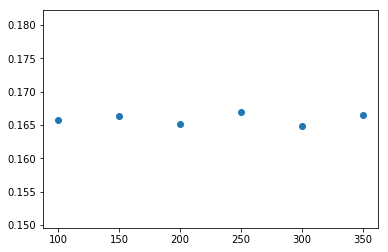

In [47]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
samples = np.array([100, 150, 200, 250, 300, 350])
sample_time = np.empty((1, 6))
model = MiniBatchKMeans(k=3, metric='euclidean', max_iter=100, random_state=10, init='random', b_size=70)
for i, sample in enumerate(samples):
    X, y = make_blobs(n_samples=sample, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    res = %timeit -o model.fit(X, y)
    sample_time[0, i] = res.best
plt.scatter(samples, sample_time) 

Из графика видно, что алгоритм существенно не зависит от размера сэмпла. Он зависит от размера выборки из базы и количества итераций. Покажем это для размера выборки.

1 loop, best of 3: 245 ms per loop
1 loop, best of 3: 340 ms per loop
1 loop, best of 3: 456 ms per loop
1 loop, best of 3: 557 ms per loop
1 loop, best of 3: 669 ms per loop
1 loop, best of 3: 787 ms per loop


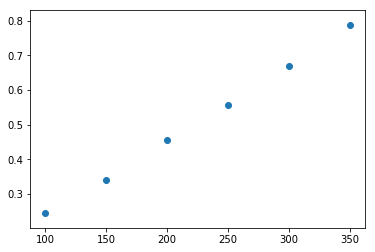

In [48]:
n_point = 1000
batches = np.array([100, 150, 200, 250, 300, 350])
sample_time = np.empty((1, 6))
X, y = make_blobs(n_samples=n_point, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
for i, b_size in enumerate(batches):
    model = MiniBatchKMeans(k=3, metric='euclidean', max_iter=100, random_state=10, init='random', b_size=b_size)
    res = %timeit -o model.fit(X, y)
    sample_time[0, i] = res.best
plt.scatter(batches, sample_time) 

10 loops, best of 3: 171 ms per loop
1 loop, best of 3: 162 ms per loop
10 loops, best of 3: 173 ms per loop
10 loops, best of 3: 165 ms per loop
10 loops, best of 3: 165 ms per loop
10 loops, best of 3: 165 ms per loop


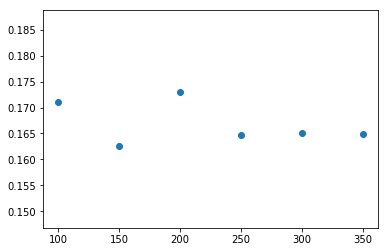

In [49]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans

samples = np.array([100, 150, 200, 250, 300, 350])
sample_time = np.empty((1, 6))
model = MiniBatchKMeans(k=3, metric='euclidean', max_iter=100, random_state=10, init='k-means', b_size=70)
for i, sample in enumerate(samples):
    X, y = make_blobs(n_samples=sample, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    res = %timeit -o model.fit(X, y)
    sample_time[0, i] = res.best
plt.scatter(samples, sample_time) 

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [24]:
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [25]:
data = df_sns.iloc[:, 4:]
data_norm =np.array((data - data.mean(axis=0))/data.std(axis=0))


In [26]:
## KMeans
model = Kmeans(k=9, max_iter=300, random_state=1234)
model.fit(data_norm)
res_kmeans = pd.DataFrame(model.centroids, columns=data.columns)
res_kmeans

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0.365049,0.353693,0.133478,0.154125,0.115555,0.210408,0.157082,0.239967,0.143135,0.833520,...,0.410168,0.639428,0.261063,1.201737,0.174808,0.279492,1.570476,0.593944,1.990846,3.045424
1,-0.105903,-0.139992,-0.069582,-0.094098,-0.094007,-0.086966,-0.093140,-0.105085,-0.000094,-0.112976,...,-0.010436,-0.060149,-0.122850,-0.047441,-0.125341,-0.119427,0.397990,2.723576,0.030689,-0.011172
2,-0.013362,0.021901,0.055708,-0.058329,-0.017585,0.020840,0.445073,-0.094615,0.067140,-0.094492,...,0.018605,0.707767,1.065677,0.619651,-0.022824,-0.059385,0.040702,-0.151956,0.042740,-0.047933
3,0.099905,0.064403,0.012346,0.043236,-0.017682,-0.009390,0.000359,-0.039949,0.042087,-0.051069,...,0.004060,-0.056320,0.055470,0.051259,-0.109720,-0.117990,0.211058,0.217167,0.047232,0.061892
4,0.134326,0.179398,0.149692,0.088903,0.170994,0.116326,0.217363,0.060540,0.029124,0.108601,...,0.043951,0.414956,0.341919,0.342925,0.049496,0.073351,0.052238,0.015859,0.074615,0.007833
5,-0.003040,0.049867,0.088457,-0.018056,0.052283,5.240994,-0.031661,0.054697,0.045554,-0.018149,...,0.009324,0.102299,0.346079,0.115914,-0.047519,-0.080196,-0.008735,-0.031175,0.057416,-0.079819
6,-0.183720,-0.196861,-0.073079,-0.129338,-0.121018,-0.149578,-0.121659,-0.143356,-0.052536,-0.152789,...,-0.030512,-0.203320,-0.263005,-0.211003,-0.159481,-0.149898,-0.117597,-0.261526,-0.098606,-0.115871
7,0.155987,0.227963,0.107566,0.068547,0.196759,0.179851,0.394473,0.029335,0.141947,0.102166,...,0.057550,0.608812,0.791273,0.559824,4.151506,4.015815,0.048335,0.087335,0.039097,0.049049
8,1.243444,1.278795,0.377022,1.020767,0.845509,-0.027051,0.077960,1.179091,0.171972,1.035967,...,0.037131,-0.028353,-0.057973,-0.025678,-0.117538,-0.125978,-0.071330,-0.104518,-0.071549,-0.094126


In [27]:
series_list = []
columns = ['1 max', '2 max','3 max', '4 max', '5 max']
index = []
for i in xrange(9):
    new = res_kmeans.iloc[i].nlargest(5)
    series_list.append(pd.Series(new.index, index=columns))
    index.append('centr {}'.format(i + 1))
pd.DataFrame(series_list, index=index)

,1 max,2 max,3 max,4 max,5 max
centr 1,kissed,drugs,hair,sex,drunk
centr 2,death,die,god,music,rock
centr 3,shopping,cute,dress,dance,mall
centr 4,bible,jesus,god,church,music
centr 5,hot,cute,sexy,mall,clothes
centr 6,swimming,shopping,music,band,clothes
centr 7,blonde,tennis,soccer,marching,jesus
centr 8,hollister,abercrombie,shopping,mall,clothes
centr 9,football,basketball,baseball,sports,softball


In [28]:
## KMeans++
model = Kmeans(k=9, max_iter=300, random_state=1234, init='k-means')
model.fit(data_norm)
res_kmeans_plus = pd.DataFrame(model.centroids, columns=data.columns)
res_kmeans_plus

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0.553116,0.533975,0.196059,0.261130,0.202509,0.389576,0.218323,0.396290,0.189948,1.116755,...,0.562297,0.654055,0.455204,1.711299,0.403083,0.507174,1.558966,0.842823,1.202009,1.962168
1,0.883711,0.918720,0.501161,0.625778,0.589549,0.262718,0.406681,0.691228,0.261734,0.678946,...,0.042415,0.384908,0.548825,0.337549,-0.045481,-0.092548,-0.012877,0.056685,-0.132553,-0.072706
2,0.128637,0.170685,0.030697,0.071410,0.093475,0.032673,0.115525,-0.049063,0.091599,-0.062124,...,0.007958,0.428287,0.656294,0.247932,0.016665,-0.011433,0.036095,0.055273,-0.053983,-0.014710
3,0.116702,-0.004957,0.025779,0.011703,-0.014317,0.077837,0.006639,-0.031466,0.011545,-0.043197,...,0.013112,-0.070761,0.031196,0.060370,-0.091093,-0.106010,0.245343,0.324517,-0.010610,0.108974
4,0.146649,0.203700,0.090904,0.068113,0.193777,0.249895,0.364925,0.018638,0.139742,0.096825,...,0.059824,0.603570,0.858897,0.591139,4.086548,3.998720,0.053472,0.120041,0.013565,0.040619
5,-0.058610,-0.059708,0.006966,-0.000596,0.001017,0.065471,0.083880,-0.050891,-0.042424,-0.086218,...,0.006641,0.151043,0.134354,0.067133,-0.084859,-0.050874,-0.032578,-0.042073,-0.076549,-0.083875
6,-0.032349,0.024187,-0.036079,-0.034335,-0.044778,0.050473,0.037074,-0.037636,-0.058214,0.143638,...,0.044407,0.341474,0.002288,0.253339,-0.091434,-0.070617,1.211204,0.835639,3.449247,2.147582
7,-0.139660,0.005969,-0.076778,-0.034856,-0.093446,0.032190,-0.116186,-0.118768,0.012412,-0.125748,...,-0.014065,-0.117261,-0.079276,-0.033191,-0.167680,-0.141109,-0.021660,0.003782,-0.109479,-0.080693
8,-0.190794,-0.206279,-0.106699,-0.134107,-0.128110,-0.086075,-0.111374,-0.136151,-0.059643,-0.160093,...,-0.028746,-0.155969,-0.187123,-0.163232,-0.154181,-0.148152,-0.097676,-0.080549,-0.146612,-0.126138


In [29]:
series_list = []
columns = ['1 max', '2 max','3 max', '4 max', '5 max']
index = []
for i in xrange(9):
    new = res_kmeans_plus.iloc[i].nlargest(5)
    series_list.append(pd.Series(new.index, index=columns))
    index.append('centr {}'.format(i + 1))
pd.DataFrame(series_list, index=index)

,1 max,2 max,3 max,4 max,5 max
centr 1,kissed,sex,hair,drugs,rock
centr 2,football,basketball,baseball,sports,softball
centr 3,dress,shopping,dance,cute,mall
centr 4,bible,jesus,god,church,death
centr 5,hollister,abercrombie,shopping,mall,clothes
centr 6,hot,sexy,cute,mall,shopping
centr 7,drunk,drugs,die,hair,death
centr 8,marching,band,music,rock,swimming
centr 9,blonde,tennis,jesus,death,bible


In [30]:
## KMeans с MiniBatchKMeans
model = MiniBatchKMeans(k=9, max_iter=400, random_state=1234, b_size=6000)
model.fit(data_norm)
res_minibatch = pd.DataFrame(model.centroids, columns=data.columns)
res_minibatch

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0.425211,0.418046,0.162519,0.186539,0.162270,0.238854,0.209169,0.329037,0.144686,0.951225,...,0.478689,0.677309,0.303435,1.159248,0.218571,0.299812,1.880249,0.703768,1.982519,3.124706
1,-0.045610,-0.052437,-0.034181,-0.011659,-0.049537,-0.089211,-0.043839,-0.040641,0.017176,-0.029444,...,-0.008531,-0.029183,-0.098945,-0.118405,-0.123434,-0.119858,0.263671,2.666829,0.064549,0.006687
2,0.695609,0.360827,0.167346,0.627925,0.679276,0.039858,0.028328,0.261446,0.114120,0.415379,...,0.016571,0.461360,0.795943,1.718888,-0.037531,-0.084347,0.017695,-0.135267,0.033299,-0.028595
3,0.140007,0.106756,0.046436,0.064410,0.015025,-0.020409,0.013097,0.156623,0.129861,0.047341,...,0.009417,0.001009,0.139646,0.047241,-0.102825,-0.119851,0.170938,0.094768,0.019162,0.008594
4,0.162367,0.187365,0.161390,0.100754,0.184176,0.130889,0.222895,0.097654,0.019482,0.129510,...,0.046363,0.417362,0.320220,0.285085,0.033595,0.074788,0.045709,0.009710,0.101169,0.008964
5,-0.019659,0.063815,0.101843,0.001299,0.058767,5.243928,-0.013912,0.079027,0.036466,0.021686,...,0.013649,0.088694,0.334240,0.060872,-0.042163,-0.066623,-0.003038,-0.023983,0.048914,-0.063277
6,-0.126538,-0.115666,-0.054228,-0.096530,-0.099788,-0.146024,-0.116828,-0.060354,-0.041092,-0.099144,...,-0.028724,-0.178007,-0.220223,-0.271744,-0.153186,-0.149251,-0.121559,-0.261511,-0.097419,-0.114190
7,0.161785,0.253258,0.119924,0.069362,0.183124,0.169693,0.451023,0.037003,0.143132,0.117691,...,0.068725,0.722095,0.903113,0.489939,3.588887,3.685194,0.069842,0.086022,0.085150,0.173659
8,-0.001499,0.202966,0.088246,-0.019063,-0.071041,-0.025196,0.510648,0.015956,0.018508,-0.025454,...,0.025985,0.259565,0.263132,-0.191861,-0.099052,-0.140947,0.064135,-0.167146,0.012932,-0.050416


In [31]:
series_list = []
columns = ['1 max', '2 max','3 max', '4 max', '5 max']
index = []
for i in xrange(9):
    new = res_minibatch.iloc[i].nlargest(5)
    series_list.append(pd.Series(new.index, index=columns))
    index.append('centr {}'.format(i + 1))
pd.DataFrame(series_list, index=index)

,1 max,2 max,3 max,4 max,5 max
centr 1,kissed,drugs,hair,sex,drunk
centr 2,death,die,sexy,god,rock
centr 3,clothes,shopping,basketball,volleyball,softball
centr 4,church,bible,jesus,god,music
centr 5,hot,cute,mall,sexy,dance
centr 6,swimming,shopping,music,cute,soccer
centr 7,blonde,tennis,soccer,baseball,bible
centr 8,abercrombie,hollister,shopping,mall,hair
centr 9,band,marching,cute,dance,cheerleading


In [34]:
## KMeans++ с MiniBatchKMeans
model = MiniBatchKMeans(k=9, max_iter=10, random_state=1234, init='k-means', b_size=6000)
model.fit(data_norm)
res_minibatch_plus = pd.DataFrame(model.centroids, columns=data.columns)
res_minibatch_plus

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0.485346,0.613822,0.294219,0.140682,0.115180,0.363073,0.253161,0.398098,0.162963,0.967612,...,0.639503,0.524232,0.451414,1.932984,0.451149,0.378012,2.135726,1.613372,1.388385,1.058928
1,0.264513,0.245288,0.199229,0.013157,0.137133,0.258191,0.069796,0.049551,0.054549,0.035217,...,0.031924,1.536053,1.094039,0.522622,0.012882,-0.063875,0.032815,0.090875,0.002740,-0.097273
2,0.231570,0.269543,0.114881,0.060646,0.080745,0.004636,0.164696,-0.028540,0.083957,-0.047163,...,0.041336,0.544726,0.704321,0.478994,0.048196,-0.003399,0.080914,0.047692,0.068111,-0.047110
3,0.152245,0.153871,0.097152,0.144867,0.039844,0.046922,0.062371,0.162058,0.136216,0.149377,...,0.001343,0.074437,0.163505,0.163439,-0.065524,-0.124653,0.182825,0.342477,-0.088651,-0.017470
4,0.351296,0.346080,0.117239,1.242036,0.379248,0.301149,1.597336,0.198915,0.106081,0.385748,...,0.074264,0.388982,0.752408,0.531510,2.938961,3.089280,0.030212,0.099036,0.063852,0.023213
5,0.012026,0.028738,0.059139,0.016172,0.054634,0.055892,0.052615,0.048036,-0.011952,0.013392,...,0.008499,-0.018920,0.084087,0.022954,-0.040715,-0.056850,-0.052272,-0.031118,0.020014,-0.080669
6,0.067990,0.086143,0.038167,0.070765,0.054953,0.080904,0.043940,0.078366,-0.005844,0.374777,...,0.107397,0.332343,0.088923,0.468074,-0.034072,0.044403,0.712211,0.327041,1.601141,3.939345
7,-0.189374,-0.080665,-0.217807,-0.171307,-0.062013,-0.082102,-0.117932,-0.068940,-0.168936,0.142077,...,-0.033182,0.092665,-0.217559,0.318108,-0.201473,0.104785,14.944600,4.475164,0.211581,0.457157
8,-0.084253,-0.080195,-0.043888,-0.076386,-0.060386,-0.065340,-0.098669,-0.039396,-0.017166,-0.073256,...,-0.026232,-0.254723,-0.218151,-0.167637,-0.143880,-0.144218,-0.096123,-0.072777,-0.089154,-0.133303


In [35]:
series_list = []
columns = ['1 max', '2 max','3 max', '4 max', '5 max']
index = []
for i in xrange(9):
    new = res_minibatch_plus.iloc[i].nlargest(5)
    series_list.append(pd.Series(new.index, index=columns))
    index.append('centr {}'.format(i + 1))
pd.DataFrame(series_list, index=index)

,1 max,2 max,3 max,4 max,5 max
centr 1,kissed,hair,sex,music,die
centr 2,mall,shopping,dance,cute,clothes
centr 3,dress,cute,shopping,hair,mall
centr 4,church,bible,god,jesus,death
centr 5,abercrombie,hollister,cheerleading,softball,shopping
centr 6,hot,sexy,cute,dance,shopping
centr 7,drugs,drunk,hair,sexy,kissed
centr 8,die,death,god,hair,kissed
centr 9,marching,tennis,blonde,baseball,band


## Вывод

K-means и K-means++ выдали похожие центры кластеров. Причем, почти во всех кластерах первые 5 максимальные значения имееют общий смысл. Это говорит о том, что кластеризация прошла успешно. 

Центры MiniBatchKMeans и MiniBatchKMeans++ пересекаются с центрами Kmeans, но не совпадают. Это показывает, что MiniBatch выдает больше шума, но при этом он работает быстрее на больших данных. 
 